## CENSUS DATA

## Segmentation / Clustering

#### Customer Segmentation

To better understand population structure beyond income prediction, we apply unsupervised clustering to identify groups of individuals with similar socioeconomic characteristics. This helps reveal interpretable population segments such as working professionals, low-workforce individuals, and high-capital individuals.

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [23]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


In [24]:
DATA_DIR = Path("./")  
COL_PATH = DATA_DIR / "census-bureau.columns"
DATA_PATH = DATA_DIR / "census-bureau.data"

In [25]:
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

def savefig(name):
    path = os.path.join(PLOTS_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved:", path)

In [26]:
# Reading column names file
with open("census-bureau.columns") as f:
    cols = [line.strip() for line in f if line.strip()]

print("Columns loaded:", len(cols))

# Reload data with headers
df = pd.read_csv("census-bureau.data", header=None, names=cols)

print(df.columns.tolist())
df.head()

Columns loaded: 42
['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefi

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [27]:
# Target is created in the next cell (after replacing "?" with NaN)

In [28]:
# Replace ? with NaN 
df = df.replace("?", np.nan)

# Target from label values 
df["target"] = df["label"].astype(str).str.contains(r"50000\+").astype(int)

# Sanity check
print(df["target"].value_counts())

target
0    187141
1     12382
Name: count, dtype: int64


In [29]:
missing = df.isna().mean().sort_values(ascending=False)
missing.head(15)

migration code-change in msa                  0.499672
migration code-change in reg                  0.499672
migration code-move within reg                0.499672
migration prev res in sunbelt                 0.499672
country of birth father                       0.033645
country of birth mother                       0.030668
country of birth self                         0.017006
hispanic origin                               0.004380
state of previous residence                   0.003548
citizenship                                   0.000000
own business or self employed                 0.000000
detailed household and family stat            0.000000
fill inc questionnaire for veteran's admin    0.000000
family members under 18                       0.000000
num persons worked for employer               0.000000
dtype: float64

In [30]:
# Drop rows where target missing 
df = df.dropna(subset=["target"])

In [31]:
# Defining Feature list + column names 
CLUSTER_COLS = [
    "age",
    "weeks worked in year",
    "wage per hour",
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "num persons worked for employer",
    "own business or self employed",
]

WEIGHT_COL = "weight"
TARGET_COL = "target"

missing = [c for c in CLUSTER_COLS + [WEIGHT_COL, TARGET_COL] if c not in df.columns]
print("Missing required columns:", missing)

Missing required columns: []


In [32]:
# Consistency checks (types, NaN/Inf, ranges, weight sanity)
seg_raw = df[CLUSTER_COLS + [WEIGHT_COL, TARGET_COL]].copy()

# Force numeric for clustering cols (catches hidden strings)
for c in CLUSTER_COLS:
    seg_raw[c] = pd.to_numeric(seg_raw[c], errors="coerce")

print("=== Segmentation Data Checks ===")
print("Shape:", seg_raw.shape)

print("\nAny NaN in CLUSTER_COLS:", seg_raw[CLUSTER_COLS].isna().any().any())
print("NaN rate by col:\n", (seg_raw[CLUSTER_COLS].isna().mean().sort_values(ascending=False)).head(10))

print("\nAny Inf in CLUSTER_COLS:", np.isinf(seg_raw[CLUSTER_COLS].to_numpy()).any())

# Weight sanity
w = pd.to_numeric(seg_raw[WEIGHT_COL], errors="coerce")
print("\nWeight NaN rate:", w.isna().mean())
print("Weight <= 0 rate:", (w <= 0).mean())
print("Weight min/median/max:", float(w.min()), float(w.median()), float(w.max()))
print("Weight sum:", float(w.sum()))

# Target sanity
print("\nTarget unique values:", sorted(seg_raw[TARGET_COL].dropna().unique().tolist()))

# Basic range checks
print("\nRange checks:")
print("age min/max:", seg_raw["age"].min(), seg_raw["age"].max())
print("weeks worked min/max:", seg_raw["weeks worked in year"].min(), seg_raw["weeks worked in year"].max())
print("num persons worked min/max:", seg_raw["num persons worked for employer"].min(), seg_raw["num persons worked for employer"].max())
print("own business min/max:", seg_raw["own business or self employed"].min(), seg_raw["own business or self employed"].max())



=== Segmentation Data Checks ===
Shape: (199523, 10)

Any NaN in CLUSTER_COLS: False
NaN rate by col:
 age                                0.0
weeks worked in year               0.0
wage per hour                      0.0
capital gains                      0.0
capital losses                     0.0
dividends from stocks              0.0
num persons worked for employer    0.0
own business or self employed      0.0
dtype: float64

Any Inf in CLUSTER_COLS: False

Weight NaN rate: 0.0
Weight <= 0 rate: 0.0
Weight min/median/max: 37.87 1618.31 18656.3
Weight sum: 347245892.46999997

Target unique values: [0, 1]

Range checks:
age min/max: 0 90
weeks worked min/max: 0 52
num persons worked min/max: 0 6
own business min/max: 0 2


In [33]:
# Clean + transform (log + winsorize) + scale -> X_cluster
seg = seg_raw.copy()

# Fill missing numeric values (if coercion created any)
seg[CLUSTER_COLS] = seg[CLUSTER_COLS].fillna(seg[CLUSTER_COLS].median())

# Log-transform skewed money cols (force non-negative first)
MONEY_COLS = ["wage per hour", "capital gains", "capital losses", "dividends from stocks"]
for c in MONEY_COLS:
    seg[c] = seg[c].clip(lower=0)
    seg[c] = np.log1p(seg[c])

# clip extremes to stabilize KMeans
for c in CLUSTER_COLS:
    lo, hi = seg[c].quantile([0.01, 0.99])
    seg[c] = seg[c].clip(lo, hi)

cluster_df = seg[CLUSTER_COLS].copy()

scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_df)

print("Final X_cluster check:")
print("Shape:", X_cluster.shape)
print("Any NaN:", np.isnan(X_cluster).any())
print("Any Inf:", np.isinf(X_cluster).any())
print("Mean (first 5):", X_cluster.mean(axis=0)[:5])
print("Std (first 5):", X_cluster.std(axis=0)[:5])


Final X_cluster check:
Shape: (199523, 8)
Any NaN: False
Any Inf: False
Mean (first 5): [-1.63103288e-16 -8.51840752e-17 -2.00852084e-17 -8.01271611e-18
  4.58683482e-17]
Std (first 5): [1. 1. 1. 1. 1.]


k=2 done | inertia=1.24e+06 | silhouette(sample)=0.3385
k=3 done | inertia=1.05e+06 | silhouette(sample)=0.3617
k=4 done | inertia=8.65e+05 | silhouette(sample)=0.3978
k=5 done | inertia=6.96e+05 | silhouette(sample)=0.4393
k=6 done | inertia=5.43e+05 | silhouette(sample)=0.4708
k=7 done | inertia=4.08e+05 | silhouette(sample)=0.5439
k=8 done | inertia=3.02e+05 | silhouette(sample)=0.5846

Total time: 9.0 seconds


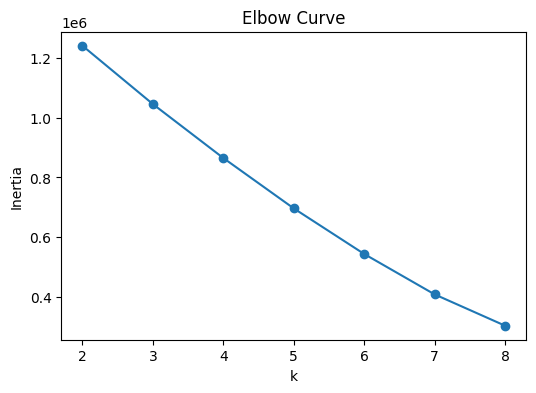

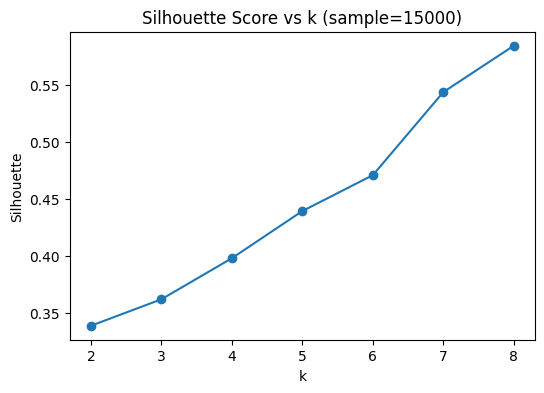

Silhouette scores: {2: np.float64(0.3384538691277812), 3: np.float64(0.36173902354745713), 4: np.float64(0.39784638158781743), 5: np.float64(0.43928939755769036), 6: np.float64(0.47083294379308793), 7: np.float64(0.5438561383436339), 8: np.float64(0.5846290460927235)}


Silhouette scores: {2: np.float64(0.3384538691277812), 3: np.float64(0.36173902354745713), 4: np.float64(0.39784638158781743), 5: np.float64(0.43928939755769036), 6: np.float64(0.47083294379308793), 7: np.float64(0.5438561383436339), 8: np.float64(0.5846290460927235)}


In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")
# Unweighted KMeans: census "weight" has a very large range (~37–18k), which causes
# numerical overflow in sklearn's weighted KMeans; we use weights only for segment analysis.
ks = range(2, 9)
inertias = []
sil_scores = []

# sample 
np.random.seed(42)
sample_n = 15000
idx = np.random.choice(X_cluster.shape[0], size=min(sample_n, X_cluster.shape[0]), replace=False)
X_sil = X_cluster[idx]

t0 = time.time()

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_full = km.fit_predict(X_cluster)
    inertias.append(km.inertia_)

    # silhouette on sample only
    labels_sample = labels_full[idx]
    sil = silhouette_score(X_sil, labels_sample)
    sil_scores.append(sil)

    print(f"k={k} done | inertia={km.inertia_:.2e} | silhouette(sample)={sil:.4f}")

print(f"\nTotal time: {time.time()-t0:.1f} seconds")

# Elbow
plt.figure(figsize=(6,4))
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

# Silhouette
plt.figure(figsize=(6,4))
plt.plot(list(ks), sil_scores, marker="o")
plt.title(f"Silhouette Score vs k (sample={len(idx)})")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

print("Silhouette scores:", dict(zip(ks, sil_scores)))


In [39]:
# Fit final KMeans 

K_FINAL = 4
kmeans = KMeans(n_clusters=K_FINAL, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_cluster)

df_seg = df.copy()
df_seg["cluster"] = cluster_labels

print("Cluster counts:")
print(df_seg["cluster"].value_counts().sort_index())


Cluster counts:
cluster
0     86972
1      7378
2      3906
3    101267
Name: count, dtype: int64


Explained variance (PC1, PC2): [0.26816465 0.15655535]


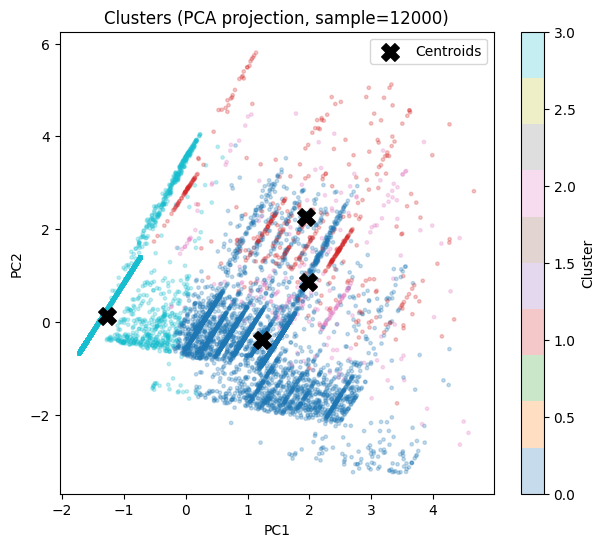

In [40]:
# PCA visualization (sampled + centroids) 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)

print("Explained variance (PC1, PC2):", pca.explained_variance_ratio_)

np.random.seed(42)
n = min(12000, X_pca.shape[0])
idx = np.random.choice(X_pca.shape[0], size=n, replace=False)

plt.figure(figsize=(7,6))
sc = plt.scatter(X_pca[idx,0], X_pca[idx,1],
                c=cluster_labels[idx], cmap="tab10",
                s=6, alpha=0.25)

centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1],
            c="black", s=160, marker="X", label="Centroids")

plt.title(f"Clusters (PCA projection, sample={n})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.colorbar(sc, label="Cluster")
plt.show()


In [ ]:
# --- Clustering with 3 PCs (new cell; no change to existing code) ---
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_cluster)
print("Explained variance (PC1, PC2, PC3):", pca3.explained_variance_ratio_)
print("Cumulative:", pca3.explained_variance_ratio_.cumsum())

kmeans3 = KMeans(n_clusters=K_FINAL, random_state=42, n_init=20)
labels_3pc = kmeans3.fit_predict(X_pca3)

# 3D visualization (sampled)
n_3d = min(12000, X_pca3.shape[0])
np.random.seed(42)
idx_3d = np.random.choice(X_pca3.shape[0], size=n_3d, replace=False)
X_plot = X_pca3[idx_3d]
labs_plot = labels_3pc[idx_3d]
centroids_3d = kmeans3.cluster_centers_

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], c=labs_plot, cmap="viridis", s=6, alpha=0.4)
ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], c="black", s=200, marker="X", label="Centroids")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"Clusters in 3-PC space (sample={n_3d})")
plt.colorbar(sc, ax=ax, label="Cluster")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# --- Cluster profile (numeric characteristics) ---
profile = df_seg.groupby("cluster")[CLUSTER_COLS].mean().round(2)
display(profile)

# --- Population share (weighted) ---
cluster_size = df_seg.groupby("cluster")[WEIGHT_COL].sum()
cluster_pct = (cluster_size / cluster_size.sum()).round(3)
display(cluster_pct)

# --- Income mix per cluster ---
mix = df_seg.groupby(["cluster", TARGET_COL])[WEIGHT_COL].sum().unstack(fill_value=0)
mix_pct = (mix.div(mix.sum(axis=1), axis=0)).round(3)
display(mix_pct)

,age,weeks worked in year,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,own business or self employed
cluster,,,,,,,,
0,38.68,46.77,114.34,0.00,0.00,175.23,3.92,0.37
1,48.50,39.45,77.76,11756.08,0.00,1028.21,3.21,0.26
2,44.19,41.39,80.24,0.00,1906.03,714.36,3.45,0.28
3,29.51,1.02,2.24,0.00,0.00,136.23,0.12,0.00


cluster
0    0.445
1    0.037
2    0.020
3    0.498
Name: weight, dtype: float64

target,0,1
cluster,,
0,0.903,0.097
1,0.669,0.331
2,0.698,0.302
3,0.995,0.005


Segment 0 :  Core Working Population
Segment 0 represents the core working population, accounting for about 44.5% of the weighted sample. Individuals in this group are typically in their late 30s, work consistently throughout the year, and earn moderate wages primarily from employment rather than investments. Capital gains and losses are almost negligible, indicating limited participation in financial markets. Only around 10% of this segment falls into the high-income category, suggesting this group reflects stable, middle-income earners. From a marketing perspective, this is a large and dependable mass-market segment suitable for broadly targeted products and services


Segment 1 : Wealth and Capital-Income Professionals
Segment 1 is a small but high-value group, representing approximately 3.7% of the population. Individuals in this segment are older, financially established, and show extremely high capital gains and dividend income, indicating strong investment activity and wealth accumulation. This segment has the highest proportion of high-income individuals at about 33%, making it the most economically affluent group. Their profile suggests professionals, investors, or high-net-worth individuals. From a marketing standpoint, this segment is ideal for premium, wealth-focused, and high-value offerings.


Segment 2 : Financially Active Mid-Career Individuals
Segment 2 represents around 2% of the population and consists of mid-career individuals with moderate employment income combined with noticeable capital losses, suggesting active participation in financial investments. Despite not having extremely high wages, this segment still shows a strong presence of high-income individuals (about 30%), likely due to broader financial activity and asset ownership. This group appears financially engaged and economically stable. From a marketing perspective, this segment is suitable for financial products, investment-related services, and targeted upselling strategies.

Segment 3 : Low Workforce Participation Group
Segment 3 is the largest segment, covering nearly 49.8% of the population. Individuals in this group are younger on average and show extremely low workforce participation, minimal wages, and almost no capital income. The probability of being in the high-income category is very small (around 0.5%), indicating limited current economic activity. This segment likely includes students, unemployed individuals, or those outside the primary labor force. From a marketing perspective, this group has lower immediate value but may represent long-term potential as their economic participation evolves over time.


While K-Means provided clear and interpretable segments, it assumes spherical clusters and requires pre-specifying the number of clusters. To validate the robustness of our segmentation and explore whether a different structure exists in the data, we additionally apply Hierarchical Clustering. Unlike K-Means, hierarchical methods do not rely on random initialization and allow us to visualize how clusters form at different levels of similarity through a dendrogram. This helps confirm whether the chosen number of segments is reasonable and ensures that our final segmentation is stable, meaningful, and not an artifact of a single clustering approach.

In [17]:
np.random.seed(42)

SAMPLE_SIZE = 4000   
idx = np.random.choice(X_cluster.shape[0], size=SAMPLE_SIZE, replace=False)

X_hier = X_cluster[idx]
print("Sample shape:", X_hier.shape)

Sample shape: (4000, 8)


In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Ward works best with standardized numeric data
Z = linkage(X_hier, method="ward")
print("Linkage matrix shape:", Z.shape)

Linkage matrix shape: (3999, 4)


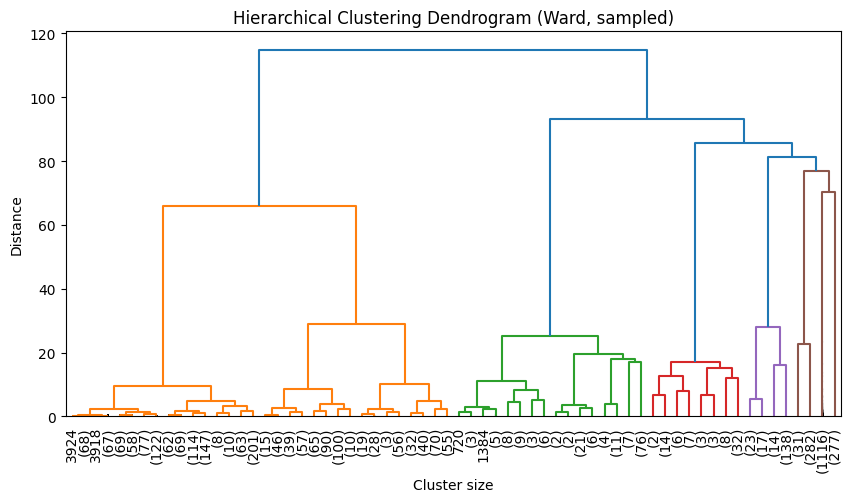

In [21]:
plt.figure(figsize=(10,5))

dendrogram(
    Z,
    truncate_mode="level",   # avoids messy full tree
    p=5,                     # show only top levels
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True,
)

plt.title("Hierarchical Clustering Dendrogram (Ward, sampled)")
plt.xlabel("Cluster size")
plt.ylabel("Distance")
plt.show()

Hierarchical clustering using Ward linkage was performed on a representative sample to validate the segmentation structure. The dendrogram shows a clear separation into four major branches with a large distance jump before merging, indicating strong natural grouping in the data. This supports the selection of k = 4 in the k-means model and confirms that the derived segments represent meaningful population structure rather than arbitrary partitioning.